In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from collections import Counter
from scipy.stats import pearsonr

import IPython

In [2]:
data_folder = '../../output-break-infl-logreg/'
data_files = {
    'hospital': ['all-experiment-data-hospital-prop-0.1-subsets-30.npz',
                 'all-experiment-data-hospital-prop-0.1-subsets-70-random_seed-1.npz',
                 'all-experiment-data-hospital-prop-0.1-subsets-100-random_seed-2.npz'],
    'imageNet': ['all-experiment-data-processed_imageNet-prop-0.09-subsets-30.npz']
}

def load_data(dataset_type, num=0):
    assert dataset_type in data_files.keys()
    f = np.load(os.path.join(data_folder, data_files[dataset_type][num]))
    train_losses=f['train_losses']
    test_losses=f['test_losses']
    pred_infl=f['pred_infl']
    grad_loss=f['grad_loss']
    test_idx=f['test_idx']
    
    random_subsets=f['random_subsets']
    neg_tail_subsets=f['neg_tail_subsets']
    pos_tail_subsets=f['pos_tail_subset']
    same_grad_subsets=f['same_grad_subsets']
    same_class_subsets=f['same_class_subsets']
    
    # clusters for same gradient subsets
    cluster_label=f['cluster_label']
    cluster_labels=f['cluster_labels']
    
    random_train_losses=f['random_train_losses']
    random_test_losses=f['random_test_losses']
    neg_tail_train_losses=f['neg_tail_train_losses']
    neg_tail_test_losses=f['neg_tail_test_losses']
    pos_tail_train_losses=f['pos_tail_train_losses']
    pos_tail_test_losses=f['pos_tail_test_losses']
    same_grad_train_losses=f['same_grad_train_losses']
    same_grad_test_losses=f['same_grad_test_losses']
    same_class_train_losses=f['same_class_train_losses']
    same_class_test_losses=f['same_class_test_losses']
    
    return train_losses, test_losses, pred_infl, grad_loss, test_idx, random_subsets, neg_tail_subsets,\
        pos_tail_subsets, same_grad_subsets, same_class_subsets, cluster_label, cluster_labels,\
        random_train_losses, random_test_losses, neg_tail_train_losses, neg_tail_test_losses,\
        pos_tail_train_losses, pos_tail_test_losses, same_grad_train_losses, same_grad_test_losses,\
        same_class_train_losses, same_class_test_losses
    
def analyze_data(dataset_type, num=0):
    def compare_pred_actual(subsets, new_test_losses, name):
        preds = []
        for subset in subsets:
            preds.append(np.sum([pred_infl[pt] for pt in subset]))
        actuals = new_test_losses[:, test_idx] - test_losses[test_idx]
        plt.scatter(actuals, preds, alpha=0.5)
        plt.xlabel('Actual Infl')
        plt.ylabel('Pred Infl')
        plt.title(dataset_type + ' ' + name + ': ' + str(pearsonr(actuals, preds)[0]))
        xlim = plt.xlim()
        ylim = plt.ylim()
        low = min(xlim[0], ylim[0])
        hi = max(xlim[1], ylim[1])
        plt.plot([low, hi, 0], [low, hi, 0], alpha=0.5)
        plt.show()
    
    train_losses, test_losses, pred_infl, grad_loss, test_idx, random_subsets, neg_tail_subsets,\
        pos_tail_subsets, same_grad_subsets, same_class_subsets, cluster_label, cluster_labels,\
        random_train_losses, random_test_losses, neg_tail_train_losses, neg_tail_test_losses,\
        pos_tail_train_losses, pos_tail_test_losses, same_grad_train_losses, same_grad_test_losses,\
        same_class_train_losses, same_class_test_losses = load_data(dataset_type, num)
    compare_pred_actual(random_subsets, random_test_losses, 'Random')
    compare_pred_actual(neg_tail_subsets, neg_tail_test_losses, 'Neg Tail')
    compare_pred_actual(pos_tail_subsets, pos_tail_test_losses, 'Pos Tail')
    compare_pred_actual(same_grad_subsets, same_grad_test_losses, 'Same Gradient')
    compare_pred_actual(same_class_subsets, same_class_test_losses, 'Same Class')

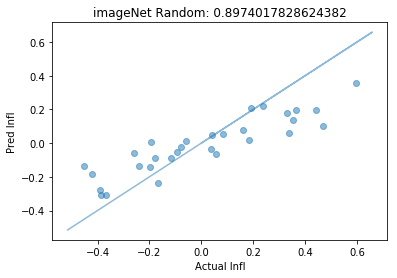

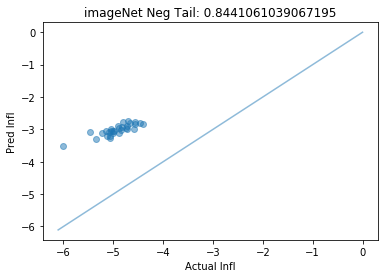

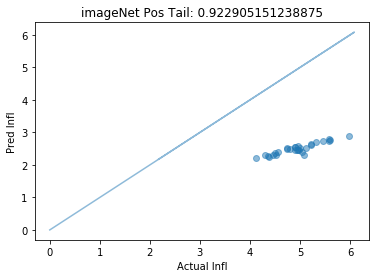

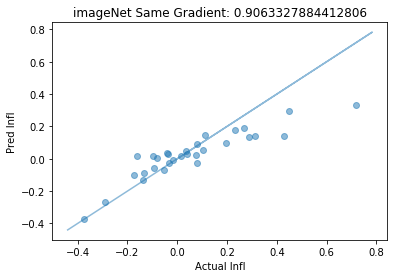

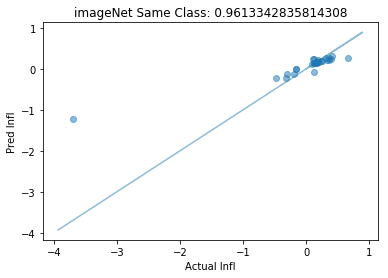

In [3]:
analyze_data('imageNet')

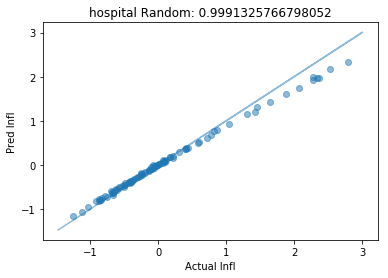

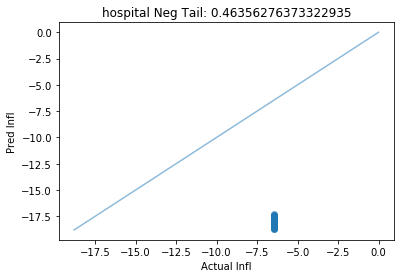

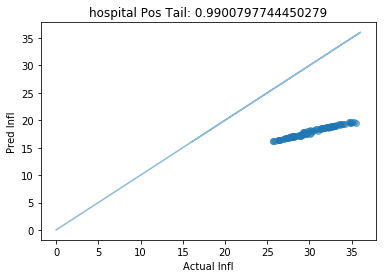

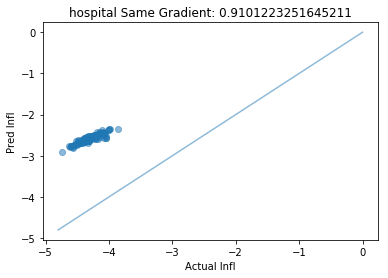

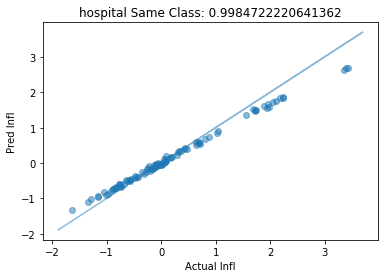

In [4]:
analyze_data('hospital', 2)

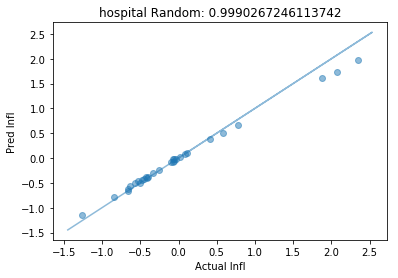

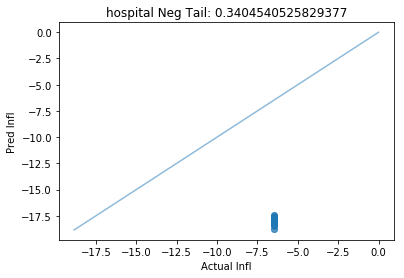

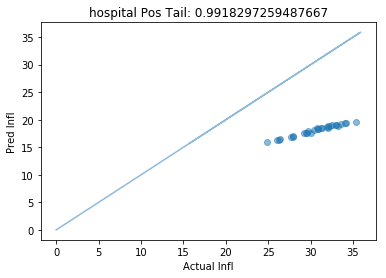

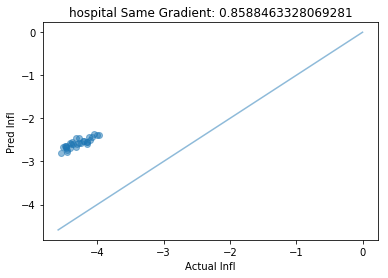

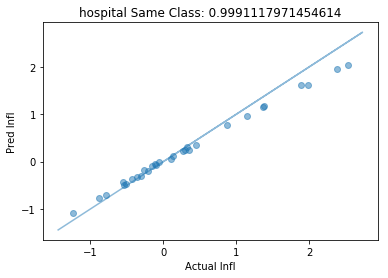

In [5]:
analyze_data('hospital', 0)

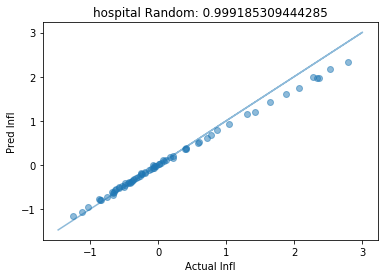

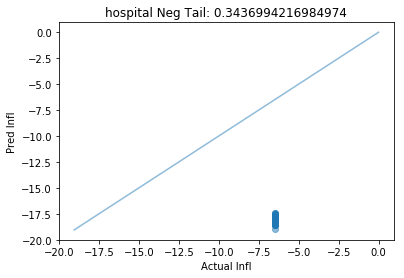

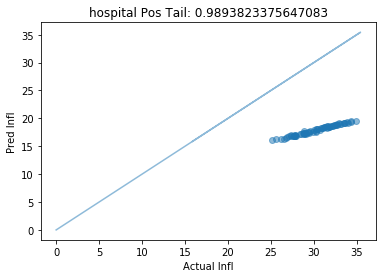

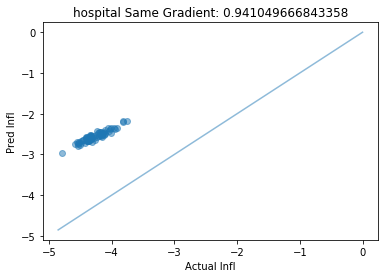

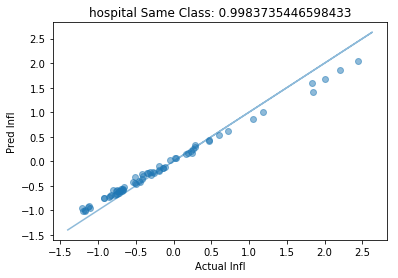

In [6]:
analyze_data('hospital', 1)

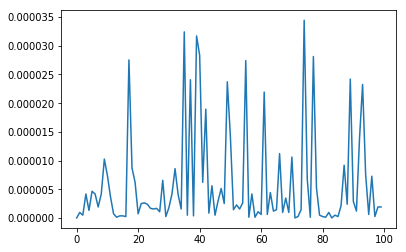

In [7]:
train_losses, test_losses, pred_infl, grad_loss, test_idx, random_subsets, neg_tail_subsets,\
        pos_tail_subsets, same_grad_subsets, same_class_subsets, cluster_label, cluster_labels,\
        random_train_losses, random_test_losses, neg_tail_train_losses, neg_tail_test_losses,\
        pos_tail_train_losses, pos_tail_test_losses, same_grad_train_losses, same_grad_test_losses,\
        same_class_train_losses, same_class_test_losses = load_data('hospital', 2)
plt.plot(neg_tail_test_losses[:,test_idx])
# for some reason, this test_idx gets ~0 loss once these points are removed.
# Therefore, the actual influence can't be that small, creating the vertical plot.

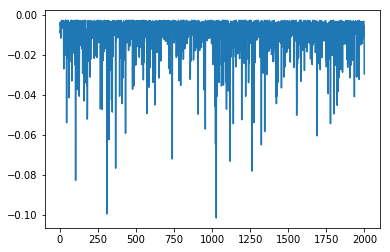

In [8]:
plt.plot(pred_infl[neg_tail_subsets[0]])

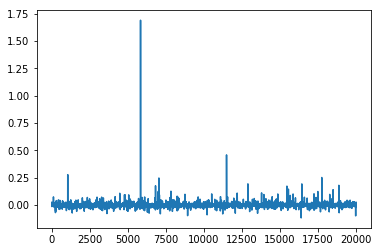

In [9]:
plt.plot(pred_infl)